# Predicting of arrival delay of a flight

Assignment problems and solutions.

### Importing all we will need

In [7]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.data import Dataset
from sklearn import model_selection
from datetime import datetime as dt
from sklearn import metrics
from matplotlib import pyplot as plt

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

### Loading train data

In [2]:
flights_data = pd.read_table('./data/flights.csv', sep=',')
flights_data = flights_data.reindex(np.random.permutation(flights_data.index))

total = flights_data.shape[0]

print(flights_data.shape)
flights_data.head()

(24193, 14)


,FL_DATE,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
10251,2018-04-13,ILM,"Wilmington, NC",12953,"New York, NY",939,1052.0,73.0,1130,1231.0,61.0,111.0,99.0,500.0
14919,2018-04-19,SDF,"Louisville, KY",12953,"New York, NY",605,557.0,-8.0,817,751.0,-26.0,132.0,114.0,659.0
18961,2018-04-24,STL,"St. Louis, MO",12953,"New York, NY",1300,1346.0,46.0,1620,1716.0,56.0,140.0,150.0,888.0
731,2018-04-01,PBI,"West Palm Beach/Palm Beach, FL",12953,"New York, NY",1608,1601.0,-7.0,1912,1915.0,3.0,184.0,194.0,1035.0
10316,2018-04-13,ATL,"Atlanta, GA",12953,"New York, NY",530,530.0,0.0,740,725.0,-15.0,130.0,115.0,762.0


In [3]:
flights_data.describe()

,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
count,24193.000000,24193.000000,24193.000000,24193.000000,24193.000000,24193.000000,24193.000000,24193.000000,24193.000000,24193.000000
mean,12747.944819,1297.970405,1306.464019,15.961890,1470.617906,1466.216716,8.430827,159.705948,152.170339,933.514033
std,235.278286,480.470027,498.578465,53.782423,520.283262,538.381581,57.276402,76.843112,75.426896,706.125616
min,12478.000000,30.000000,1.000000,-49.000000,2.000000,1.000000,-65.000000,50.000000,39.000000,94.000000
25%,12478.000000,900.000000,901.000000,-5.000000,1045.000000,1040.000000,-19.000000,102.000000,98.000000,419.000000
50%,12953.000000,1252.000000,1302.000000,-2.000000,1514.000000,1513.000000,-8.000000,136.000000,130.000000,740.000000
75%,12953.000000,1700.000000,1717.000000,12.000000,1905.000000,1914.000000,12.000000,185.000000,180.000000,1096.000000
max,12953.000000,2359.000000,2400.000000,1659.000000,2359.000000,2400.000000,1685.000000,585.000000,609.000000,4983.000000


### Understanding data

1. All given times are actual strings converted to numbers.
2. All counts are the same suggesting that there are no missing values.
3. Means of times all make sense except for minutes - they are wrong (biased), since there are no mins after 60 - but not a big deal - looks like we would not need them. The rest:<br>
   Dep time is about 1 o'clock, so there is no imbalance.<br>
   CRS dep time is 10 minutes to actual - makes sense.<br>
   CRS arr time is around 1.5 hours after dep time - makes sense.<br>
   Factual arr time is a few minutes earlier than sheduled - that's always the case based on my experience.<br>
   Time intervals and distance all as well seem to be fine.<br>
4. Std dev and percentiles all make sense as well.
5. Mins and maxes have negative numbers suggesting there are many flights arriving ahead of shedule.<br>
   Delay and elapsed time are apparently in minutes. Delays are with a few max outliers of 30 hours delay.
   

Let's visualize hists on dep time, elapsed time and distances to confirm our understanding.

In [4]:
flights_data.hist('DEP_TIME', bins = 20); None

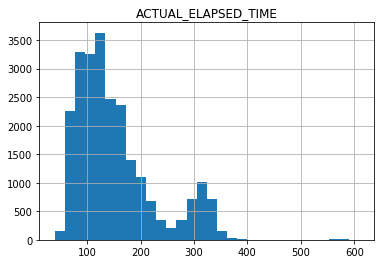

In [5]:
flights_data.hist('ACTUAL_ELAPSED_TIME', bins = 30); None

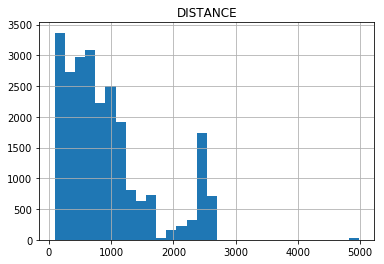

In [6]:
flights_data.hist('DISTANCE', bins = 30); None

Everything is as expected with histograms.

## Problem #1

#### a) What is the average duration of all the flights that landed in NY in April?

In [7]:
# first, let's filter out NY April flights
to_NY_in_april = (flights_data['FL_DATE'] >= '2018-04-01') &\
                 (flights_data['FL_DATE'] < '2018-05-01') &\
                 (flights_data['DEST_CITY_NAME'] == 'New York, NY')

filtered_data_size = flights_data[to_NY_in_april].shape[0]
print(f"Size of the data filtered by NY & April: {filtered_data_size} records.")
print(f"Size of the original dataset: {total} records.")

Size of the data filtered by NY & April: 24193 records.
Size of the original dataset: 24193 records.


The same number of records after filtering - looks like the question is about the whole dataset.

In [8]:
avg_dur = flights_data['ACTUAL_ELAPSED_TIME'].mean()
print(f"So, the average duration of the flights is just {avg_dur:.1f}")

So, the average duration of the flights is just 152.2


#### b) For every minute in April, compute the average duration of the flights flying at that minute. Compute the average of these averages. Can you explain the difference with a)?

In [9]:
avg_dur_by_mins = flights_data.groupby('ARR_TIME').mean()['ACTUAL_ELAPSED_TIME'].mean()
print(f"Avergae duration of hte flights grouped by minutes: {avg_dur_by_mins:.1f}")

Avergae duration of hte flights grouped by minutes: 168.8


Of course the two numbers differ. This is due to the different weight (mass function, probability) applied to the values. In **a)** the weights of durations are all equal to 1. In **b)** durations are wieghted over minutes first.

To better illustrate what I mean imagine that there are 101 flights in total. A hundred of them took place at 14:00 and lasted 1 minute each; the last one was at 22:00 and lasted 10 minutes.

In average, duration is around 1 minute. But after grouping, the weight of that only flight increased 100 times. And average duration got 5.5 minutes.

Now, back to our case. Let's plot durations per minutes and see what caused such a discrepency.

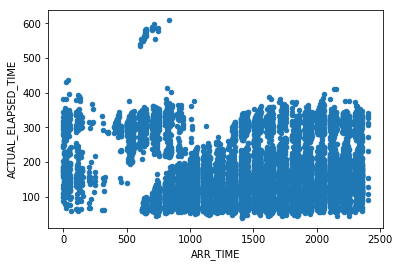

In [10]:
flights_data.plot.scatter('ARR_TIME', 'ACTUAL_ELAPSED_TIME'); None

In fact. We see that a lot of flights arrived at the daytime. They create the mass center. Night arrivals contribute just a little.

When after squashing by minutes, night flights contribute much more, having their mass at longer duration (around 300).

That is why we see the increase in duration after aggregating it by minutes. Below is just another visualization with the mass shifted towards longer duration.

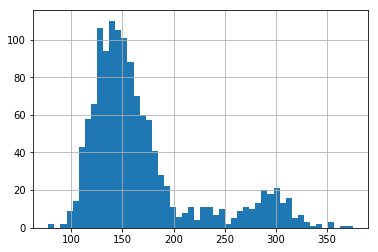

In [11]:
flights_data.groupby('ARR_TIME').mean()['ACTUAL_ELAPSED_TIME'].hist(bins = 50); None


## Problem #2

Build a model to predict the arrival delay of a flight:<br>
- beforehand
- after the departure

Explain the results.

In [3]:
# first, split data
# Given such a small dataset I'd prefer cross validation with say 5 folds. But for the purpose of
# this exercise let's get along with simple train test splitting.
training_data, validation_data = model_selection.train_test_split(flights_data, train_size = 0.8)

### Developing a feature set

Ideally, we'd like to have features that are strongly correlated with the target.<br>
We'd also like to have features that aren't so strongly correlated with each other, so that they add independent information.

First, let's see which features correlate.<br>

In [4]:
training_data.corr()

,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
DEST_AIRPORT_ID,1.0,-0.1,-0.0,0.0,0.1,0.1,0.0,-0.4,-0.4,-0.4
CRS_DEP_TIME,-0.1,1.0,0.9,0.1,0.5,0.4,0.1,0.1,0.1,0.1
DEP_TIME,-0.0,0.9,1.0,0.2,0.5,0.5,0.2,0.1,0.1,0.1
DEP_DELAY,0.0,0.1,0.2,1.0,0.1,0.1,1.0,-0.0,-0.0,-0.0
CRS_ARR_TIME,0.1,0.5,0.5,0.1,1.0,0.8,0.1,-0.0,-0.0,-0.0
ARR_TIME,0.1,0.4,0.5,0.1,0.8,1.0,0.1,-0.0,-0.0,-0.0
ARR_DELAY,0.0,0.1,0.2,1.0,0.1,0.1,1.0,-0.1,-0.0,-0.1
CRS_ELAPSED_TIME,-0.4,0.1,0.1,-0.0,-0.0,-0.0,-0.1,1.0,1.0,1.0
ACTUAL_ELAPSED_TIME,-0.4,0.1,0.1,-0.0,-0.0,-0.0,-0.0,1.0,1.0,1.0
DISTANCE,-0.4,0.1,0.1,-0.0,-0.0,-0.0,-0.1,1.0,1.0,1.0


As expected - after the departure there is a strong correlation with departure delay. But before departure - no features correlate with arr delay, just noise. So, there is no sense in using direct features. Let us see what we can do.

Back two days ago when reading the problem in a messager, my first thought was dep airports were to blame for the arrival delays. Either their location is in bad whether conditions (in April or ever), or they are overloaded with traffic and hence crammed and jammed, or the management is bad taking no actions towards improvements.

Next, perhaps there are some 'systematic' delays for certain routes.

Hour of the day may impact delays as well - perhaps morning is dirrerent from noon, from evening and night.

Weekday is important as well, as well as its cross with the origin and an hour of the day.

Let's:
- use categorical features ORIGIN and DEST_AIRPORT_ID - so far we only used numerical
- bin departure time - I do believe there is some correlation there too
- use weekdays (chances are delays dependent on days of the week due to flights traffic)
- use the cross of an origin and a weekday
- use the cross of an origin and a destination
- use the cross of an hour and a weekday

In [25]:
def create_targets(dataframe):
  result = pd.DataFrame()
  result['ARR_DELAY'] = dataframe['ARR_DELAY']
  return result

def create_examples(dataframe):
  result = pd.DataFrame()

  # Creating weekdays
  result['FL_WEEKDAY'] = dataframe['FL_DATE'].apply(lambda x: to_weekday(x)).astype('int64')
  # Bucket departure time
  result['BINNED_CRS_DEP_TIME'] = dataframe['CRS_DEP_TIME'].apply(lambda x: to_dayhour(x)).astype('int64')
  result['BINNED_CRS_ARR_TIME'] = dataframe['CRS_ARR_TIME'].apply(lambda x: to_dayhour(x)).astype('int64')
  # Creating week number
  result['WEEK_NUM'] = dataframe['FL_DATE'].apply(lambda x: to_week_num(x))
  # copying unmodified features
  result['ORIGIN']              = dataframe['ORIGIN']
  result['DEST_AIRPORT_ID']     = dataframe['DEST_AIRPORT_ID']
  result['DEP_DELAY']           = dataframe['DEP_DELAY'] # to use later
  result['ARR_DELAY']           = dataframe['ARR_DELAY'] # for the purpose of supporting hypotheses
  return result

def to_weekday(x):
  return dt.strptime(x, '%Y-%m-%d').weekday()

def to_dayhour(num):
  return int(str(num)[:-2] or 0)

def to_week_num(x):
  return dt.strptime(x, '%Y-%m-%d').isocalendar()[1]

In [26]:
# Defining vocabularies for categorical feature columns
origins_list = training_data['ORIGIN'].unique()
airports_list = training_data['DEST_AIRPORT_ID'].unique()
weekdays_list = np.arange(7)
weeknums_list = np.arange(13, 19)
hours_list = np.arange(24)

# Setting features
origin           = tf.feature_column.categorical_column_with_vocabulary_list('ORIGIN', origins_list)
weekday          = tf.feature_column.categorical_column_with_vocabulary_list('FL_WEEKDAY', weekdays_list)
weeknum          = tf.feature_column.categorical_column_with_vocabulary_list('WEEK_NUM', weeknums_list)
airport          = tf.feature_column.categorical_column_with_vocabulary_list('DEST_AIRPORT_ID', airports_list)
binned_dep_time  = tf.feature_column.categorical_column_with_vocabulary_list('BINNED_CRS_DEP_TIME', hours_list)
binned_arr_time  = tf.feature_column.categorical_column_with_vocabulary_list('BINNED_CRS_ARR_TIME', hours_list)
dep_delay        = tf.feature_column.numeric_column('DEP_DELAY')
origin_x_weekday = tf.feature_column.crossed_column((origin, weekday), 1000)
origin_x_dest    = tf.feature_column.crossed_column((origin, airport), 1000)
arr_hour_x_weekday = tf.feature_column.crossed_column((binned_arr_time, weekday), 1000)

In [35]:
train_examples = create_examples(training_data)
train_targets = create_targets(training_data)
validation_examples = create_examples(validation_data)
validation_targets = create_targets(validation_data)

In [28]:
# To support hypothesis on ORIGIN impact
train_examples.groupby('ORIGIN')['ARR_DELAY'].describe()

,count,mean,std,min,25%,50%,75%,max
ORIGIN,,,,,,,,
ABQ,21.0,9.5,49.6,-28.0,-18.0,-3.0,13.0,201.0
AGS,13.0,8.2,33.0,-44.0,-9.0,-4.0,38.0,57.0
ATL,843.0,3.7,39.2,-43.0,-18.0,-9.0,7.0,269.0
AUS,129.0,0.6,32.9,-37.0,-15.0,-8.0,2.0,166.0
BGR,93.0,16.2,112.5,-32.0,-18.0,-12.0,8.0,894.0
...,...,...,...,...,...,...,...,...
STT,4.0,-35.5,9.1,-46.0,-40.0,-36.0,-31.5,-24.0
SYR,183.0,8.3,53.7,-42.0,-19.5,-7.0,10.0,340.0
TPA,326.0,3.3,45.5,-49.0,-18.0,-10.0,1.8,317.0


In [30]:
# To support hypothesis on destination impact
train_examples.groupby('DEST_AIRPORT_ID')['ARR_DELAY'].describe()

,count,mean,std,min,25%,50%,75%,max
DEST_AIRPORT_ID,,,,,,,,
12478,8388.0,5.9,54.5,-65.0,-19.0,-8.0,10.0,1685.0
12953,10966.0,10.2,58.5,-51.0,-18.0,-8.0,14.0,1233.0


In [31]:
# To support hypothesis on FL_WEEKDAY impact
train_examples.groupby('FL_WEEKDAY')['ARR_DELAY'].describe()

,count,mean,std,min,25%,50%,75%,max
FL_WEEKDAY,,,,,,,,
0,3208.0,23.4,72.0,-53.0,-15.0,-2.0,30.0,925.0
1,2788.0,-0.6,37.2,-60.0,-19.0,-10.0,5.0,435.0
2,2647.0,24.9,70.3,-52.0,-16.0,-2.0,43.0,1233.0
3,2839.0,2.0,44.4,-58.0,-19.0,-9.0,7.0,1153.0
4,2841.0,7.3,58.2,-50.0,-16.0,-6.0,13.0,1685.0
5,1848.0,-2.6,47.5,-62.0,-22.0,-14.0,-2.0,1026.0
6,3183.0,0.2,47.9,-65.0,-21.0,-11.0,5.0,1082.0


In [32]:
# To support hypothesis on WEEK_NUM impact
train_examples.groupby('WEEK_NUM')['ARR_DELAY'].describe()

,count,mean,std,min,25%,50%,75%,max
WEEK_NUM,,,,,,,,
13,662.0,-12.1,32.0,-56.0,-26.0,-19.0,-8.0,283.0
14,4421.0,16.5,63.6,-65.0,-18.0,-4.0,25.0,1233.0
15,4617.0,0.5,48.8,-60.0,-20.0,-11.0,5.0,1082.0
16,4433.0,9.1,57.4,-58.0,-18.0,-8.0,13.0,1153.0
17,4509.0,11.4,60.9,-49.0,-17.0,-7.0,15.0,1685.0
18,712.0,3.3,30.5,-39.0,-13.0,-3.0,9.0,353.0


As you can see, we do have some correlation of the above syntetic features we just created. The means and std deviations are different when grouped by these features.

In [33]:
def my_input_fn(features, targets, batch_size=1, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [44]:
def train_model(
    learning_rate,
    l2_reg_strength,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      the dataframe to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      the dataframe to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      the dataframe to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      the dataframe to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps // periods

  # Create a linear regressor object
  # Using custom optimizer to interoduce l2 reg and gradient clips
  my_optimizer = tf.train.FtrlOptimizer(learning_rate = learning_rate,
                                        l2_regularization_strength = l2_reg_strength)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["ARR_DELAY"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["ARR_DELAY"], 
                                                  num_epochs=1)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["ARR_DELAY"], 
                                                    num_epochs=1)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE:")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f (train)" % (period, training_root_mean_squared_error))
    print("  period %02d : %0.2f (validation)" % (period, validation_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE:
  period 00 : 56.33 (train)
  period 00 : 58.75 (validation)
  period 01 : 56.02 (train)
  period 01 : 58.51 (validation)
  period 02 : 55.86 (train)
  period 02 : 58.41 (validation)
  period 03 : 55.78 (train)
  period 03 : 58.37 (validation)
  period 04 : 55.73 (train)
  period 04 : 58.36 (validation)
  period 05 : 55.71 (train)
  period 05 : 58.37 (validation)
  period 06 : 55.70 (train)
  period 06 : 58.39 (validation)
  period 07 : 55.71 (train)
  period 07 : 58.43 (validation)
  period 08 : 55.73 (train)
  period 08 : 58.46 (validation)
  period 09 : 55.75 (train)
  period 09 : 58.50 (validation)
Model training finished.


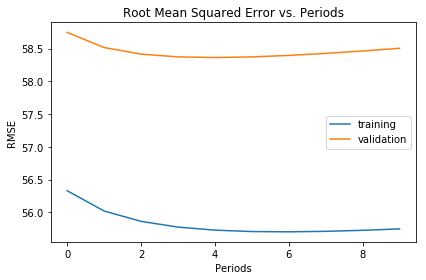

In [45]:
_ = train_model(
      learning_rate       = 1.0,
      l2_reg_strength     = 0.001, # the model does not overfit, so minimum regularization applied
      steps               = 50,
      batch_size          = 100,
      feature_columns     = set([
        origin, weekday, weeknum, airport, arr_hour_x_weekday, binned_dep_time, origin_x_weekday, origin_x_dest
      ]),
      training_examples   = train_examples,
      training_targets    = train_targets,
      validation_examples = validation_examples,
      validation_targets  = validation_targets
  )

In [47]:
std = validation_data['ARR_DELAY'].describe()['std']
std - 58.36 # min error is 58.36 # (validation)

0.7150943300546757

### Results - Problem #2, beforehand

This means that our model is better than just random pick. Although, quite underwelming, comparing to the one below which uses actual departure time.

Model generalizes well, what suggests that it needs to be investigated further to find out the feasibility of better inferencing without using factual departure time.

Training model...
RMSE:
  period 00 : 16.44 (train)
  period 00 : 16.76 (validation)
  period 01 : 15.67 (train)
  period 01 : 16.05 (validation)
  period 02 : 15.57 (train)
  period 02 : 15.96 (validation)
  period 03 : 15.53 (train)
  period 03 : 15.94 (validation)
  period 04 : 15.56 (train)
  period 04 : 16.04 (validation)
  period 05 : 15.54 (train)
  period 05 : 16.04 (validation)
  period 06 : 16.04 (train)
  period 06 : 16.66 (validation)
  period 07 : 15.91 (train)
  period 07 : 16.49 (validation)
  period 08 : 15.84 (train)
  period 08 : 16.42 (validation)
  period 09 : 15.70 (train)
  period 09 : 16.24 (validation)
Model training finished.


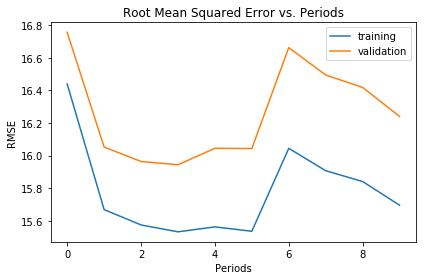

In [48]:
# Now let's add factual dep time as a feature

_ = train_model(
      learning_rate       = 1.0,
      l2_reg_strength     = 0.01,
      steps               = 500,
      batch_size          = 100,
      feature_columns     = set([
        origin, weekday, weeknum, airport, arr_hour_x_weekday, binned_dep_time,
        origin_x_weekday, origin_x_dest, dep_delay
      ]),
      training_examples   = train_examples,
      training_targets    = train_targets,
      validation_examples = validation_examples,
      validation_targets  = validation_targets
  )

### Results - Problem # 2, when using departure time

Again, the model does not overfit. Now it predicts within an error of 16 minutes. Much better than the previous model, but given the features set it is kind of expected.

As well as before, further investigation is needed to improve performance.